[nltk_data] Downloading package stopwords to /Users/nigel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nigel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 10 most frequent words:
trump: 17260
vote: 6244
people: 5906
harris: 4988
like: 4112
kamala: 4108
one: 3709
jesus: 3706
president: 3554
biden: 3434


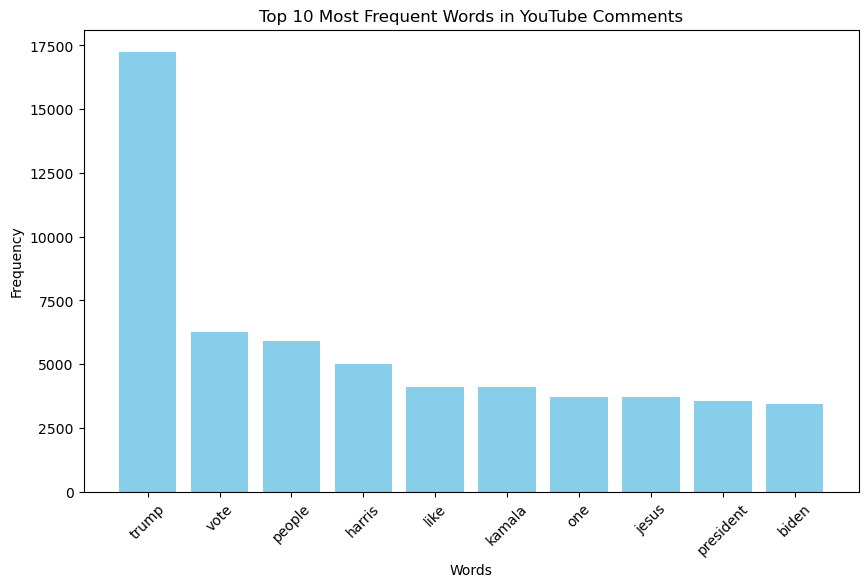

In [11]:
import pandas as pd
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords set
stop_words = set(stopwords.words('english'))

# Define a function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    return text

# Apply the cleaning function to the 'text' column
youtube_comments_df['cleaned_text'] = youtube_comments_df['text'].apply(lambda x: clean_text(str(x)))

# Tokenize the text and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove non-alphabetical tokens and stopwords
    return tokens

youtube_comments_df['tokens'] = youtube_comments_df['cleaned_text'].apply(tokenize_and_remove_stopwords)

# Flatten all tokens into a single list
all_tokens = [word for tokens in youtube_comments_df['tokens'] for word in tokens]

# Count the frequency of each word
word_counts = Counter(all_tokens)

# Get the top k most frequent words
k = 10  # You can set k to any number you like
top_k_words = word_counts.most_common(k)

# Display the top k words
print(f"Top {k} most frequent words:")
for word, count in top_k_words:
    print(f"{word}: {count}")

# Plotting the word frequency histogram
words, counts = zip(*top_k_words)  # Unzip the words and counts

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title(f"Top {k} Most Frequent Words in YouTube Comments")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [25]:
# Function to get the parent comment text if it's a reply, otherwise use the video title
def get_parent_or_video_title(row, comments_df, videos_df):
    if row['is_reply']:  # If it's a reply, find the parent comment text
        parent_comment = comments_df[comments_df['comment_id'] == row['parent_id']]
        if not parent_comment.empty:
            return parent_comment['text'].values[0]
    else:  # If it's a top-level comment, return the video title
        video = videos_df[videos_df['video_id'] == row['parent_id']]
        if not video.empty:
            return video['title'].values[0]
    return None  # If neither a reply nor a matching video is found

# Apply the function to get the appropriate context for each comment
youtube_comments_df['replying_to'] = youtube_comments_df.apply(
    lambda row: get_parent_or_video_title(row, youtube_comments_df, videos_df),
    axis=1
)

# Convert 'like_count' to numeric, and handle errors by setting invalid parsing to NaN
youtube_comments_df['like_count'] = pd.to_numeric(youtube_comments_df['like_count'], errors='coerce')

# Sort by 'like_count' to get the top liked comments
top_comments = youtube_comments_df.sort_values(by='like_count', ascending=False)

# Select top 5 comments with context
top_5_comments = top_comments[['author', 'text', 'like_count', 'published_at', 'replying_to']].head(5)

# Display the top 5 comments
print(top_5_comments)

                   author  \
301954  @soniajames-tn4mp   
253191               @wsj   
253192           @RugMann   
300142  @ThePizzaBoxer851   
246808      @s_rgamer2346   

                                                                                                                                                                           text  \
301954                                           Great video, The first $100,000 invested was amazing. But when you hit $300,000 it’s like smashing the glass ceiling! I cried.   
253191  Unsteady Biden, a Subdued Trump: The Debate Analyzed.<br><br><a href="https://www.youtube.com/watch?v=MEwbfi9t1Zs">https://youtu.be/MEwbfi9t1Zs?si=pdgGH-C69OLmQjdd</a>   
253192                                                                                                        Thats bull Biden was absolutely bodied in this debate. Trump 2024   
300142                                                                                                      T

Skipping file with no data: youtube_comments_YoLICmlVC2c.csv
Skipping file with no data: youtube_comments_1JbcfnuOLeA.csv
Skipping file with no data: youtube_comments_EhjK7P3uboE.csv
Skipping file with no data: youtube_comments_kRh6598RmHM.csv
Skipping file with no data: youtube_comments_fiIT7zrg-oM.csv
Skipping file with no data: youtube_comments_xeWSUz_tRzE.csv
Skipping file with no data: youtube_comments_Hr551AGISXQ.csv
Skipping file with no data: youtube_comments_faRdmt3My70.csv
Skipping file with no data: youtube_comments_T2K-K3xDE8Y.csv
Skipping file with no data: youtube_comments_Z2d7peX8n04.csv
Skipping file with no data: youtube_comments_tnGaMNvMqvU.csv
Skipping file with no data: youtube_comments_-a-elTAJMtI.csv
Skipping file with no data: youtube_comments_m7-IyjWCZY0.csv
Skipping file with no data: youtube_comments_yARHguIg2k0.csv
Skipping file with no data: youtube_comments_heD-px37WFE.csv
Skipping file with no data: youtube_comments_qK2Zn5oCCq8.csv
Skipping file with no da

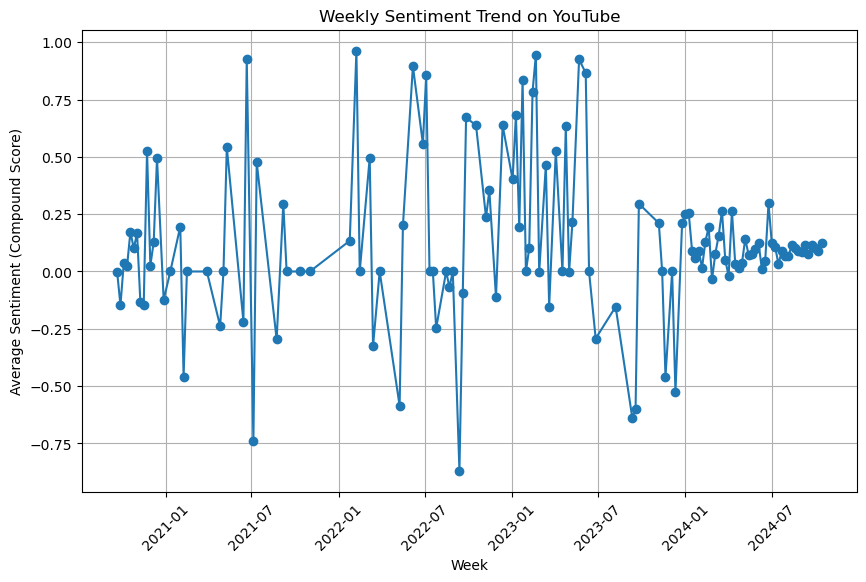

In [18]:
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Define the folder where the comment files are stored
comments_folder = 'youtube_data'

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to load all YouTube comments from the CSV files
def load_youtube_comments(comments_folder):
    all_comments = pd.DataFrame()

    for file_name in os.listdir(comments_folder):
        if file_name.startswith('youtube_comments_') and file_name.endswith('.csv'):
            file_path = os.path.join(comments_folder, file_name)
            try:
                video_comments = pd.read_csv(file_path)
                if not video_comments.empty:  # Check if the file is not empty
                    all_comments = pd.concat([all_comments, video_comments], ignore_index=True)
                else:
                    print(f"Skipping empty file: {file_name}")
            except pd.errors.EmptyDataError:
                print(f"Skipping file with no data: {file_name}")
    
    return all_comments

# Load the YouTube comments
youtube_comments_df = load_youtube_comments(comments_folder)

# Convert the 'published_at' column to datetime using ISO 8601 format
youtube_comments_df['published_at'] = pd.to_datetime(youtube_comments_df['published_at'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')

# Drop rows where 'published_at' could not be converted (NaT values)
youtube_comments_df = youtube_comments_df.dropna(subset=['published_at'])

# Apply VADER sentiment analysis
def apply_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Add sentiment score to the DataFrame
youtube_comments_df['sentiment'] = youtube_comments_df['text'].apply(lambda x: apply_sentiment(str(x)))

# Extract the week number for weekly grouping
youtube_comments_df['week'] = youtube_comments_df['published_at'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and calculate the average sentiment per week
weekly_sentiment_youtube = youtube_comments_df.groupby('week')['sentiment'].mean().reset_index()

# Plot the trend of weekly sentiment for YouTube data
plt.figure(figsize=(10, 6))
plt.plot(weekly_sentiment_youtube['week'], weekly_sentiment_youtube['sentiment'], marker='o')
plt.title('Weekly Sentiment Trend on YouTube')
plt.xlabel('Week')
plt.ylabel('Average Sentiment (Compound Score)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()